## Image Reconstruction using Convolutional Autoencoder on CIFAR10 Subset Data
### Problem Description
#### The goal of this assignment is to build a Convolutional Autoencoder (CAE) for image reconstruction using a subset of the CIFAR dataset. The CIFAR dataset consists of 60,000 32x32 color images in 10 different classes. For this assignment, you will be provided with a subset of the CIFAR dataset consisting of 40 images for training and 8 images for testing, selected from one or more classes.

### Objectives
#### Understand the structure and components of Convolutional Autoencoders.
#### Implement a Convolutional Autoencoder using PyTorch to reconstruct images from the CIFAR subset.
#### Train the Autoencoder on the provided training data and evaluate its performance on the test data.

### Input
#### CIFAR-10 Subset: The dataset contains images categorized into the following 10 classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck. But for this assignment the subset contains only first four classes: airplane, automobile, bird and cat
#### Training Data: 40 images
#### Testing Data: 8 images
#### Model Architecture: You will design and implement a Convolutional Autoencoder model, which may include convolutional layers, pooling layers, upsampling layers, and a latent space representation.

### Import Required Libraries

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn

### Preprocessing and EDA

In [2]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    #transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

#### Load training and testing data

In [3]:
# Define a custom dataset class
class CustomCIFAR10Dataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        
        img, label = self.data[idx], self.labels[idx]
        img = img.transpose((1, 2, 0))  # Convert to HWC format
        img = Image.fromarray(img.astype('uint8'))  # Convert to PIL image
        if self.transform:
            img = self.transform(img)
        return img, label

In [4]:
# Load the saved CIFAR10 data subsets using PyTorch
train_subset_data = np.load('data/train_cifar.npy')
train_subset_labels = np.load('data/train_cifar_target.npy')
test_subset_data = np.load('data/test_cifar10.npy')
test_subset_labels = np.load('data/test_cifar_target.npy')

#### Initialize train and test loaders

In [5]:
# Create an instance of the CustomCIFAR10Dataset for the training subset,
# using the provided training data and labels, and apply the specified transformations.
train_dataset = CustomCIFAR10Dataset(train_subset_data, train_subset_labels, transform=transform)

In [6]:
# Create an instance of the CustomCIFAR10Dataset for the test subset,
# using the provided test data and labels, and apply the specified transformations.
# hint: test_dataset = <>
### BEGIN SOLUTION
test_dataset = CustomCIFAR10Dataset(test_subset_data, test_subset_labels, transform=transform)
### END SOLUTION

In [7]:
# Create a DataLoader for the training dataset with a batch size of 4 and shuffling enabled.
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

In [8]:
# Print some information about the subsets
print(f'Train Size: {len(train_dataset)}')
print(f'Test Size: {len(test_dataset)}')
# Example of iterating through the DataLoader
for images, labels in train_loader:
    print(f'Batch of images shape: {images.shape}')
    print(f'Batch of labels shape: {labels.shape}')
    break   

Train Size: 40
Test Size: 8
Batch of images shape: torch.Size([4, 3, 28, 28])
Batch of labels shape: torch.Size([4])


In [9]:
# Create a DataLoader for the test dataset with a batch size of 4 and shuffling disabled.
# hint: test_loader = <>
### BEGIN SOLUTION
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)
### END SOLUTION

In [10]:
### BEGIN HIDDEN TESTS

# Check if test_dataset is an instance of CustomCIFAR10Dataset
assert isinstance(test_dataset, CustomCIFAR10Dataset), "test_dataset should be an instance of CustomCIFAR10Dataset"

# Check if the length of the dataset matches the number of labels
assert len(test_dataset) == len(test_subset_labels), "Length of test_dataset should match the length of test_subset_labels"

### END HIDDEN TESTS

In [11]:
### BEGIN HIDDEN TESTS

# Check if test_loader is an instance of DataLoader
assert isinstance(test_loader, DataLoader), "test_loader should be an instance of DataLoader"

# Check if the batch_size is correctly set
assert test_loader.batch_size == 4, "Batch size of test_loader should be 4"

### END HIDDEN TESTS

In [12]:
# Define the list of class names corresponding to the CIFAR-10 dataset labels.
# hint1: Check the problem description and the input at the beginning of this Notebook
# hint2: classes = ['airplane', 'automobile'....]

### BEGIN SOLUTION
classes = ['airplane', 'automobile', 'bird', 'cat']
### END SOLUTION

In [13]:
### BEGIN HIDDEN TESTS

# Check if classes is a list
assert isinstance(classes, list), "classes should be a list"

# Check if the length of classes is 4
assert len(classes) == 4, "classes should contain exactly 10 elements"

# Check if the content of classes matches the expected class names
expected_classes = ['airplane', 'automobile', 'bird', 'cat']
assert classes == expected_classes, "classes does not match the expected class names"

### END HIDDEN TESTS

#### Display random images from training and testing dataset

In [14]:
# Utility functions to un-normalize and display an image
def imshow(img):
    img = img / 2 +0.5
    plt.imshow(np.transpose(img, (1, 2, 0)))

automobile bird  bird  bird 


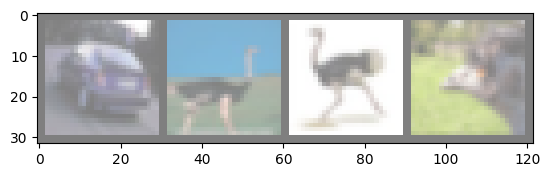

In [15]:
# Get some random training images for display

# Create an iterator from the training data loader
train_dataiter = iter(train_loader)
# Get the next batch of images and labels from the iterator
images, labels = next(train_dataiter)  

# Show images
# Display the images in a grid using the imshow function
imshow(torchvision.utils.make_grid(images))  

# Print labels
# Print the labels of the images in the batch
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))
plt.show()

In [16]:
### BEGIN HIDDEN TESTS
# DEFINE HERE AND USE MULTIPLE PLACES IN FUTURE HIDDEN TESTS
import re
def check_method_order(method_names):
    # Retrieve the previous cell's content
    code_string = In[-2]
    # print(code_string)
    method_call_patterns = [
        fr'{method_name.split("(")[0]}\s*\(\s*.*?\s*\)'
        for method_name in method_names
    ]

    # Find all occurrences of the patterns
    occurrences = []
    for pattern in method_call_patterns:
        match = re.search(pattern, code_string)
        if match:
            occurrences.append((match.start(), pattern))
   
    # Check if occurrences are in the correct order
    occurrences.sort()  # Sort by the starting position of the matches
    sorted_patterns = [pattern for _, pattern in occurrences]
   
    return sorted_patterns == method_call_patterns
### END HIDDEN TESTS

airplane airplane automobile automobile


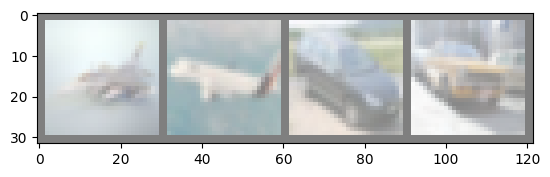

In [17]:
# Get some random test images for display
# Step1: Create an iterator from the test data loader
# Step2: Get the next batch of images and labels from the iterator
# Step3: Display the images in a grid using the imshow function
# Step4: Print the labels of the images in the batch
# hint: Refer the code in the above cell that displays training images

### BEGIN SOLUTION
test_dataiter = iter(test_loader)
images, labels = next(test_dataiter)  
imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))
plt.show()
### END SOLUTION

In [18]:
### BEGIN HIDDEN TESTS
import collections.abc
# Check if test_dataiter is an iterator
assert isinstance(test_dataiter, collections.abc.Iterator), "test_dataiter should be an iterator"

methods = [
    "iter",
    "next",
    "make_grid" 
]
result = check_method_order(methods)
print(result)
assert result == True
### END HIDDEN TESTS

True


### Design simple Convolutional AutoEncoder architecture

#### Design the following Convolutional AutoEncoder Neural Network architecture for Image Processing
#### and reconstruction, apply the Pooling, Activation functions as per the below design

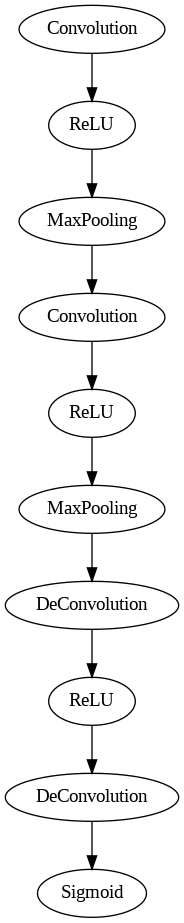

In [19]:
# Define the Convolutional Autoencoder
class ConvAutoEncoder(nn.Module):
    def __init__(self):
        super(ConvAutoEncoder, self).__init__()
        
        # Encoder Layers
        # First convolutional layer: input channels = 3 (RGB image), output channels = 16, 
        #                            3x3 kernel size, padding = 1
        # Second convolutional layer: input channels = 16, output channels = 4, 
        #                            3x3 kernel size, padding = 1
        # Max pooling layer with 2x2 kernel, and stride = 2 to downsample feature maps
        #
        # Decoder Layers
        # First transposed convolution (deconvolution) layer: 
        #                            input channels = 4, output channels = 16, 
        #                            2x2 kernel, stride = 2
        # Second transposed convolution (deconvolution) layer: 
        #                           input channels = 16, output channels = 3, 
        #                           2x2 kernel, stride = 2
        ## hint: Use Class variables, e.g self.conv1, self.pool, self.t_conv1
        #
        ### BEGIN SOLUTION
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 3, 2, stride=2)
        ### END SOLUTION
        
    def forward(self, x):
        # Apply the first convolutional layer followed by ReLU activation
        # Apply max pooling to reduce spatial dimensions
        # Apply the second convolutional layer followed by ReLU activation
        # Apply max pooling again to further reduce spatial dimensions
        # Apply the first transposed convolution layer followed by ReLU activation to begin reconstruction
        # Apply the second transposed convolution layer followed by Sigmoid activation to reconstruct the image
        #
        ### BEGIN SOLUTION
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.t_conv1(x))
        x = F.sigmoid(self.t_conv2(x))
        ### END SOLUTION
        return x

In [20]:
# Instantiate the model
model = ConvAutoEncoder()
print(model)

ConvAutoEncoder(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 3, kernel_size=(2, 2), stride=(2, 2))
)


In [32]:
### BEGIN HIDDEN TESTS

# List to store the layers
layers = list(model.modules())

# Assertions to check the network architecture
# Conv1
assert isinstance(layers[1], nn.Conv2d), "First layer is not Conv2d"
assert layers[1].in_channels == 3, "Conv1 in_channels should be 3"

# Conv2
assert isinstance(layers[2], nn.Conv2d), "Second layer is not Conv2d"
assert layers[2].out_channels == 4, "Conv2 out_channels should be 4"

# Pool
assert isinstance(layers[3], nn.MaxPool2d), "Fourth layer is not MaxPool2d"
assert layers[3].kernel_size == 2, "Pool kernel_size should be (2, 2)"

# T_Conv1
assert isinstance(layers[4], nn.ConvTranspose2d), "Fifth layer is not ConvTranspose2d"
assert layers[4].kernel_size == 2 or layers[4].kernel_size == (2,2), "T_Conv1 kernel_size should be (2, 2)"
assert layers[4].stride == (2, 2), "T_Conv1 stride should be (2, 2)"

# T_Conv2
assert isinstance(layers[5], nn.ConvTranspose2d), "Sixth layer is not ConvTranspose2d"
assert layers[5].in_channels == 16, "T_Conv2 in_channels should be 16"
assert layers[5].out_channels == 3, "T_Conv2 out_channels should be 3"

### END HIDDEN TESTS


#### Select loss and optimizer functions

In [22]:
# Set loss function and optimizer
# Use Binary Cross Entropy loss and assign it to criterion object
# Create and initialize the loss function to Binary Cross Entropy Loss

### BEGIN SOLUTION
criterion = nn.BCELoss()
### END SOLUTION

# Create and initialize the optimizer to Adam optimizer
# The learning rate (lr) is set to 0.001, which controls the step size for updating the model parameters
### BEGIN SOLUTION
optimizer = optim.Adam(model.parameters(), lr=0.001)
### END SOLUTION

In [23]:
### BEGIN HIDDEN TESTS

# Function to check if an instance of a specific class exists in the local scope and 
# if its attributes are set correctly
def assert_instance_in_scope(class_type, attribute_checks, scope, error_message):
    instance_found = False
    for var_value in scope.values():
        if isinstance(var_value, class_type):
            instance_found = True
            for attr, expected_value in attribute_checks.items():
                actual_value = eval(f"var_value.{attr}")
                assert actual_value == expected_value, f"{class_type.__name__} {attr} is {actual_value}, expected {expected_value}"
            break
    assert instance_found, error_message

# Get all variables in the current local scope
local_vars = locals()

# Assert that there is an instance of nn.CrossEntropyLoss in the local scope
assert_instance_in_scope(nn.BCELoss, {}, local_vars, "No instance of nn.BCELoss found")

# Assert that there is an instance of optim.Adam in the local scope and the learning rate is set correctly
assert_instance_in_scope(optim.Adam, {'param_groups[0]["lr"]': 0.001}, local_vars, "No instance of optim.Adam with correct learning rate found")

### END HIDDEN TESTS

In [24]:
# Training function
# hint1: train(model, train_loader, <loss_function_obj>, <optimizer_obj>, num_epochs=2)
# hint2: replace criterion and optimizer with your <loss_function_obj> and <optimizer_obj> respectively
def train(model, train_loader, criterion, optimizer, num_epochs=2):    
    # Set the model to training mode
    # This is important for certain layers like dropout and batch normalization, 
    #                     which behave differently during training and evaluation
    model.train()
    for epoch in range(num_epochs):
        # Initialize the running loss to zero before starting the training loop
        # Loop over the training data in batches
        #    Zero the gradients for the optimizer
        #    Forward pass: compute the model output for the given inputs
        #    Compute the loss between the predicted outputs and the actual labels
        #    Backward pass: compute the gradient of the loss with respect to model parameters
        #    Perform a single optimization step to update the model parameters
        #    Accumulate the loss for reporting
        #    Print the average loss for every <n> mini-batches
        ### BEGIN SOLUTION
        
        running_loss = 0.0
        for data in train_loader:
            images, _ = data
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()*images.size(0)
        
        train_loss = running_loss/len(train_loader)
        print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))
    print('Finished Training')
        
        ### END SOLUTION        
    

In [25]:
### BEGIN HIDDEN TESTS

methods = [
    "zero_grad",
    "model",
    "backward",
    "step"
   
]
result = check_method_order(methods)
print(result)
assert result == True
### END HIDDEN TESTS

True


In [34]:
# Train the model
num_epochs = 5
# Invoke the train function to kick off the learning
# Pass arguments: model, loader, loss, optimizer, num of epochs
# hint: train(model, train_loader, <loss_function_obj>, <optimizer_obj>, num_epochs)
### BEGIN SOLUTION
train(model, train_loader, criterion, optimizer, num_epochs)
### END SOLUTION

Epoch: 0 	Training Loss: 2.733007
Epoch: 1 	Training Loss: 2.709761
Epoch: 2 	Training Loss: 2.689414
Epoch: 3 	Training Loss: 2.669638
Epoch: 4 	Training Loss: 2.647954
Finished Training


In [35]:
### BEGIN HIDDEN TESTS

methods = [
    "train"
   
]
result = check_method_order(methods)
print(result)
assert result == True

### END HIDDEN TESTS

True


In [27]:
# Batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)

In [28]:
# Sample outputs
output = model(images)
images = images.numpy()

In [29]:
# Ensure the output shape is correct
print(f'Output shape: {output.shape}')  # Should be [4, 3, 32, 32]

Output shape: torch.Size([4, 3, 28, 28])


In [30]:
batch_size = 4
output = output.view(batch_size, 3, 28, 28)
output = output.detach().numpy()

Original Images


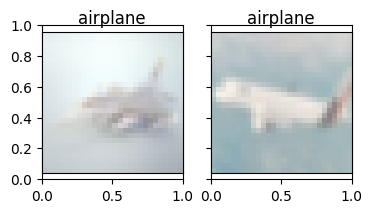

Reconstructed Images


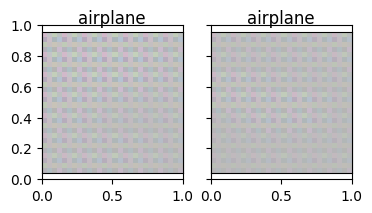

In [31]:
# Original images
print("Original Images")
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(4,2))
for idx in np.arange(2):
    ax = fig.add_subplot(1, 2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])
plt.show()

# Reconstructed images
print("Reconstructed Images")
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(4, 2))
for idx in np.arange(2):
    ax = fig.add_subplot(1, 2, idx+1, xticks=[], yticks=[])
    imshow(output[idx])
    ax.set_title(classes[labels[idx]])
    
plt.show()